In this notebook i will illustrate how to obtain some mesoscopic features using the library. I will focus on two of main concepts:

<ol>
<li>Accessibility -> Gravity model & cumulative</li>
<li>Accessibility -> Walk score (requires API Key)</li>
</ol>

A visualization that i would like to illstrate as part of this is how street attributes vary as you follow a path through the network. 

Just as a conceptual recap the Gravity-based accessibility for a point $p$ can be defined in the following manner:

$$A(p) = \sum_{j} \frac{O(a_{j})}{e^{d(p, a_{j})}}$$

where $O(a_{j})$ is the weight or importance of amenity $a_{j}$, and $d(p, a_{j})$ is a measure of how "far" is the pont from $a_{j}$ you should think of $d$ not as a distance necessarily but as a metric in general, it could also be time, or a distance refined based on perceptions. 

The cumulative accessibility is defined in the following way:

$$A(p) = \sum_{j} O(a_j) \cdot \mathbb{1}\left( d(p, a_j) \leq \tau \right)$$

It tells you how many important amenities you can reach within a distance. 

Walk-score is a black box, you need to request an API key to use it, but i provide a function to calculate the walk score for a set of given points. and projecting the results to the street network. 

### Gravity-based accessibility

In [1]:
from alivestreets.features.mesoscopic import compute_gravity_accessibilities
from alivestreets.sampling.street_sampler import StreetSampler
import os
import geopandas as gpd

#Let's open the street network, we learn how to obtain that 
#in a previous notebook 
path_network = os.path.join(os.getcwd(), "data", "network.geojson")
sampler = StreetSampler(200)
sampler.open_streets(path_network)
print(f"Opened network, the number of streets is {len(sampler.streets)}")

#We will examine accessibility from points in the network to amenities, for instance
#bus stops. 
sampler.sample_streets_no_intersections()
sampling_points = sampler.get_all_sampling_points()

#Open the parks geojson, we learned how to obtain these files in the previous notebook
path_bus_stops = os.path.join(os.getcwd(), "data", "features", "bus_stops.geojson")
bus_gdf = gpd.read_file(path_bus_stops)
busses = list(bus_gdf["geometry"])
busses = [[p.x, p.y] for p in busses]

Opened network, the number of streets is 268


In [2]:
#Once everything is loaded you can calculate the gravity-based accessibility for all the sampling
#points. It might take a while to finish. 
from alivestreets.network.graph_utilities import build_graph_from_sampler

graph = build_graph_from_sampler(sampler)
weights  = [1.0]*len(sampling_points)
gravity_based_access = compute_gravity_accessibilities(
    sampling_points,
    busses, 
    weights,
    graph, 
    distance_type = "network", 
    beta = 0.001
)

  1%|          | 4/355 [00:00<00:42,  8.33it/s]/Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/CFC/alivestreets/alivestreets/.venv/lib/python3.11/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/CFC/alivestreets/alivestreets/.venv/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
100%|██████████| 355/355 [00:47<00:00,  7.43it/s]


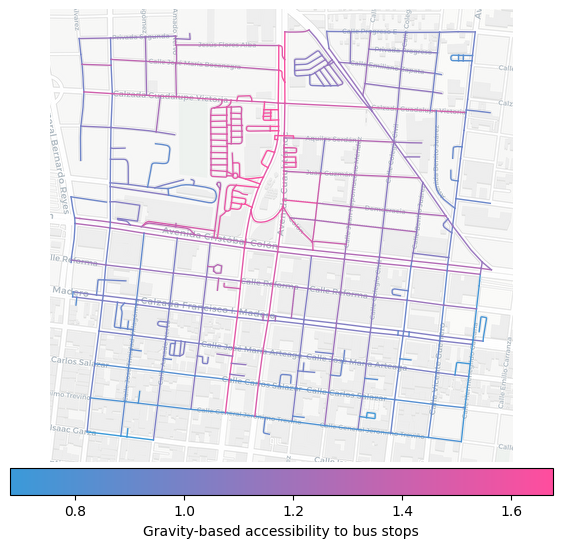

In [3]:
#Tag and visualize the accessibility

sampler.tag_streets(
    "gravity_based_access", 
    gravity_based_access, 
    method = "mean"
)

from alivestreets.visualization.map_visualizer import MapVisualizer

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))
vis.add_street_sampler(sampler, 
"gravity_based_access", 
variable_type="continuous",
edge_width = 1)

vis.draw_networks(colorbar_label = "Gravity-based accessibility to bus stops", colorbar_orientation = "horizontal")

vis.add_basemap(alpha = 0.9)
vis.finalize_map()

### Cumulative accessibility

In [4]:
from alivestreets.features.mesoscopic import compute_cumulative_accessibilities
cumulative_access =  compute_cumulative_accessibilities(
    sampling_points,
    busses, 
    weights,
    graph, 
    distance_type = "network", 
    threshold = 400
)

100%|██████████| 355/355 [00:49<00:00,  7.17it/s]


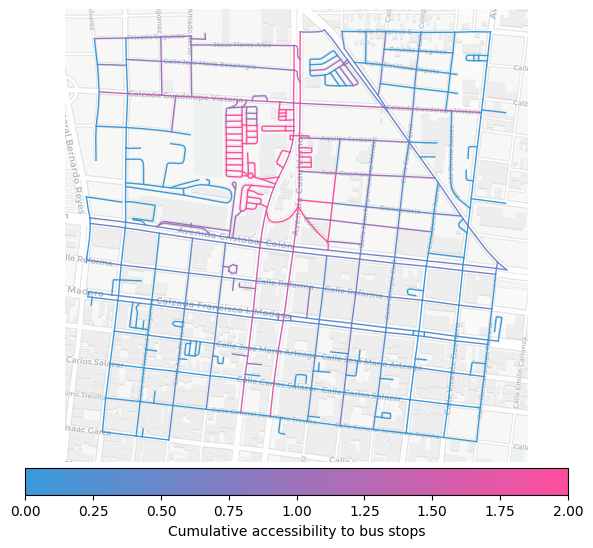

In [5]:
sampler.tag_streets(
    "cumulative_access", 
    cumulative_access, 
    method = "mean"
)


vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))
vis.add_street_sampler(sampler, 
"cumulative_access", 
variable_type="continuous",
edge_width = 1)

vis.draw_networks(colorbar_label = "Cumulative accessibility to bus stops", colorbar_orientation = "horizontal")

vis.add_basemap(alpha = 0.9)
vis.finalize_map()


In [6]:
from alivestreets.network.graph_utilities import attach_sampler_segment_attributes_to_graph

In [7]:
attach_sampler_segment_attributes_to_graph(graph, 
sampler, 
"gravity_based_access", 
aggregation = "mean")

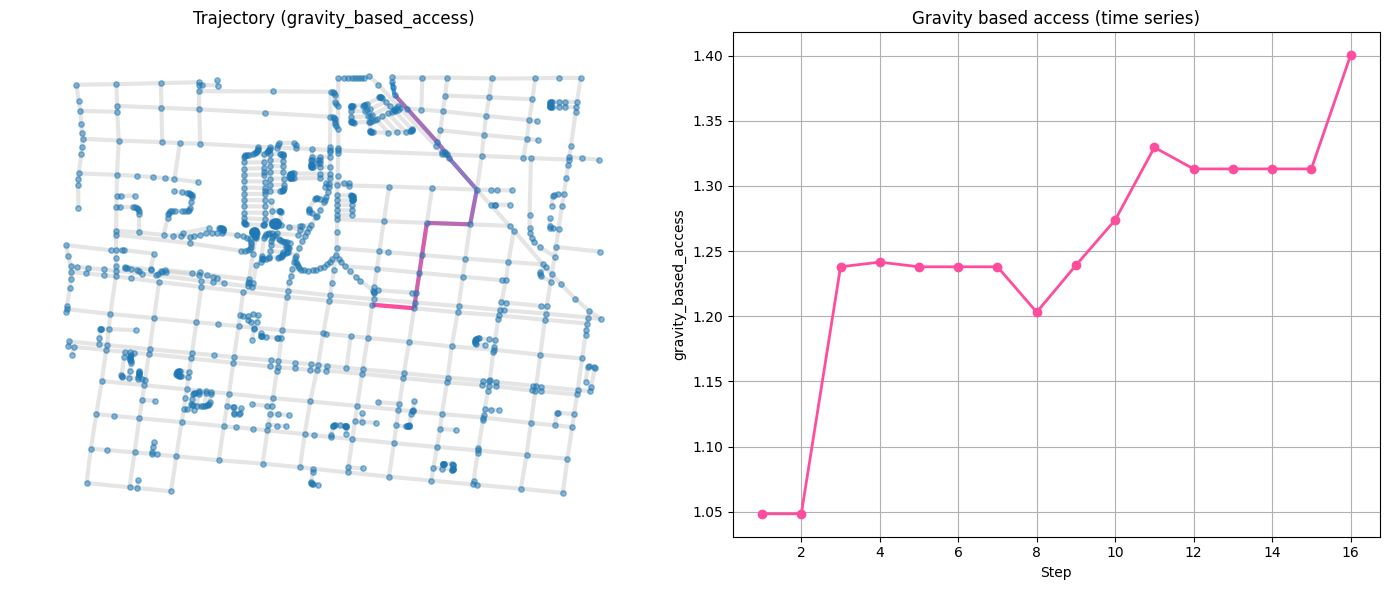

In [8]:
from alivestreets.visualization.trajectory_visualizer import plot_trajectory_on_graph, plot_attribute_time_series
import networkx as nx
import matplotlib.pyplot as plt

initial_node = 10
final_node = 1
undirected_graph = graph.to_undirected()

trajectory = nx.shortest_path(undirected_graph, source=initial_node, target=final_node, weight="length")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the trajectory on the graph
plot_trajectory_on_graph(
    G=undirected_graph,
    trajectory=trajectory,
    attribute_name="gravity_based_access",
    edge_size = 3.0,
    width = 3.0, 
    node_size = 15,
    ax=ax1
)

# Plot the time series
plot_attribute_time_series(
    trajectory=trajectory,
    G=undirected_graph,
    attribute_name="gravity_based_access",
    ax=ax2, 
    title = "Gravity based access (time series)"
)

plt.tight_layout()
plt.show()